In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

train = pd.read_csv("./data_format2/train_format2.csv")

train.head()
#User' s age range: 1 for <18;     2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 
#                   5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50;
#0 and NULL for unknown.
# activity_log
#Set of interaction records between {user_id, merchant_id}, 
#where each record is an action represented as 
#' item_id:category_id:brand_id:time_stamp:action_type' . ' #' is used to separate two neighbouring elements. 
#Records are not sorted in any particular order.

# time: mmdd

#act_type:{0, 1, 2, 3}, 
#      0 is for click, 
#      1 is for add-to-cart
#      2 is for purchase 
#      3 is for add-to-favourite

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030723 entries, 0 to 7030722
Data columns (total 6 columns):
user_id         int64
age_range       float64
gender          float64
merchant_id     int64
label           int64
activity_log    object
dtypes: float64(2), int64(3), object(1)
memory usage: 321.8+ MB


In [64]:
train.describe()

,user_id,age_range,gender,merchant_id,label
count,7.030723e+06,7.011343e+06,6.969011e+06,7.030723e+06,7.030723e+06
mean,2.120120e+05,3.106246e+00,3.036947e-01,2.455233e+03,-9.606277e-01
std,1.223200e+05,1.914345e+00,5.319517e-01,1.456245e+03,2.058154e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,1.055770e+05,2.000000e+00,0.000000e+00,1.176000e+03,-1.000000e+00
50%,2.126810e+05,3.000000e+00,0.000000e+00,2.404000e+03,-1.000000e+00
75%,3.175440e+05,4.000000e+00,1.000000e+00,3.743000e+03,-1.000000e+00
max,4.241700e+05,8.000000e+00,2.000000e+00,4.995000e+03,1.000000e+00


In [65]:
train.isnull().sum()

user_id             0
age_range       19380
gender          61712
merchant_id         0
label               0
activity_log     2975
dtype: int64

In [66]:
train=train.fillna(np.nan)
train.isnull().sum()

user_id             0
age_range       19380
gender          61712
merchant_id         0
label               0
activity_log     2975
dtype: int64

In [67]:
train.head()

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [68]:
# since 7,030,723 is too big for desktop PC, we just select 100,000 for test

log_test = train.iloc[:,:].copy()

# Just ignore the former buyer(label=-1)
log_test = log_test[log_test.label != -1]

# Fill the log with '' in order to to string.split()
log_test['activity_log']=log_test['activity_log'].fillna('')


# 0 for unknow age describled in the official site
# 2 for unknow gender describled in the official site
# but we wanna see the mean and std, so change these values to NaN
# and then to insert with the vaule which we want.(i.e. mean, mode, etc.)
log_test.loc[log_test['age_range']==0,'age_range']=np.nan
log_test.loc[log_test['gender']==2,'gender']=np.nan
log_test.head()

,user_id,age_range,gender,merchant_id,label,activity_log
6,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...
30,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...
40,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...
63,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0
117,230784,NaN,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...


In [69]:
log_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 6 to 7030721
Data columns (total 6 columns):
user_id         260864 non-null int64
age_range       203802 non-null float64
gender          250170 non-null float64
merchant_id     260864 non-null int64
label           260864 non-null int64
activity_log    260864 non-null object
dtypes: float64(2), int64(3), object(1)
memory usage: 13.9+ MB


In [70]:
# item_id:category_id:brand_id:time_stamp:action_type
# act_type:{0, 1, 2, 3}, 
#      0 is for click, 
#      1 is for add-to-cart
#      2 is for purchase 
#      3 is for add-to-favourite
#log_test['log_list'] = log_test['activity_log'].apply(lambda x: [i.split(':') for i in x.split('#')])
log_test['item_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[0] for i in x.split('#')])
#log_test['cat_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[1] for i in x.split('#')])
#log_test['brand_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[2] for i in x.split('#')])
#log_test['time_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[3] for i in x.split('#')])
#log_test['act_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[4] for i in x.split('#')])
log_test['act_times'] = log_test['item_list'].apply(len)
log_test['click'] = log_test['activity_log'].apply(lambda x: [i.split(':').count('0') for i in x.split('#')].count(1))
log_test['add_cart'] = log_test['activity_log'].apply(lambda x: [i.split(':').count('1') for i in x.split('#')].count(1))
log_test['purchase'] = log_test['activity_log'].apply(lambda x: [i.split(':').count('2') for i in x.split('#')].count(1))
log_test['add_fav'] = log_test['activity_log'].apply(lambda x: [i.split(':').count('3') for i in x.split('#')].count(1))
log_test.drop(['activity_log'],axis=1,inplace=True)

In [71]:
#[i.split(':')[2] for i in log_test.loc[6763768,'activity_log'].split('#')]

In [72]:
#log_test['cat_list'] = log_test['activity_log'].apply(lambda x: [i.split(':') for i in x.split('#')])
#log_test['cat_list']

In [73]:
log_test.info()
log_test.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 6 to 7030721
Data columns (total 11 columns):
user_id        260864 non-null int64
age_range      203802 non-null float64
gender         250170 non-null float64
merchant_id    260864 non-null int64
label          260864 non-null int64
item_list      260864 non-null object
act_times      260864 non-null int64
click          260864 non-null int64
add_cart       260864 non-null int64
purchase       260864 non-null int64
add_fav        260864 non-null int64
dtypes: float64(2), int64(8), object(1)
memory usage: 23.9+ MB


,user_id,age_range,gender,merchant_id,label,act_times,click,add_cart,purchase,add_fav
count,260864.000000,203802.000000,250170.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000
mean,211889.321420,3.768403,0.294824,2540.292363,0.061151,10.798558,9.077044,0.000092,1.369518,0.386826
std,122399.488027,1.298597,0.455964,1451.207514,0.239607,19.805637,19.032752,0.016381,1.146741,1.426118
min,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,105488.000000,3.000000,0.000000,1340.000000,0.000000,3.000000,2.000000,0.000000,1.000000,0.000000
50%,211927.500000,4.000000,0.000000,2482.000000,0.000000,6.000000,4.000000,0.000000,1.000000,0.000000
75%,317670.500000,5.000000,1.000000,3898.000000,0.000000,12.000000,10.000000,0.000000,1.000000,0.000000
max,424170.000000,8.000000,1.000000,4993.000000,1.000000,3918.000000,3917.000000,7.000000,132.000000,107.000000


In [74]:
log_test.head()

,user_id,age_range,gender,merchant_id,label,item_list,act_times,click,add_cart,purchase,add_fav
6,34176,6.0,0.0,3906,0,"[757713, 757713, 757713, 718096, 757713, 61369...",39,36,0,1,2
30,34176,6.0,0.0,121,0,"[800752, 800752, 800752, 800752, 800752, 80075...",14,13,0,1,0
40,34176,6.0,0.0,4356,1,"[709909, 709909, 709909, 709909, 709909, 70990...",18,12,0,6,0
63,34176,6.0,0.0,2217,0,"[399879, 399879]",2,1,0,1,0
117,230784,NaN,0.0,4818,0,"[155695, 155695, 155695, 155695, 155695, 15569...",8,7,0,7,0


In [75]:
# user number
log_test.user_id.value_counts().sum()
# merchant number
log_test.merchant_id.value_counts().sum()

260864

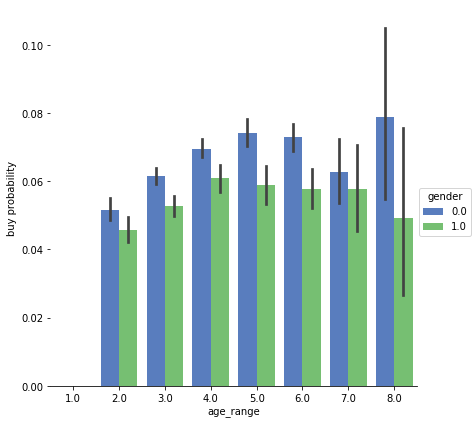

In [76]:
# Explore age_range vs label by gender
g = sns.factorplot(x="age_range", y="label", hue="gender", data=log_test[log_test.gender.notnull() & log_test.age_range.notnull()],
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("buy probability")

In [77]:
log_test[["age_range","label"]].groupby('age_range').mean()

,label
age_range,
1.0,0.000000
2.0,0.049346
3.0,0.058816
4.0,0.067220
5.0,0.069990
6.0,0.068338
7.0,0.060437
8.0,0.069444


In [78]:
log_test['age_range'].value_counts()

3.0    69369
4.0    51235
2.0    31026
5.0    25618
6.0    21701
7.0     4120
8.0      720
1.0       13
Name: age_range, dtype: int64

In [79]:
# from the 2 lines above, we may assume NaN age can be 3 or 4 with 50-50%
log_test.loc[log_test['age_range'].isnull(),'age_range'] = np.random.binomial(1,0.5)+3

In [80]:
log_test['age_range'].isnull().sum()

0

In [81]:
log_test[["gender","label"]].groupby('gender').mean()

,label
gender,
0.0,0.064547
1.0,0.053813


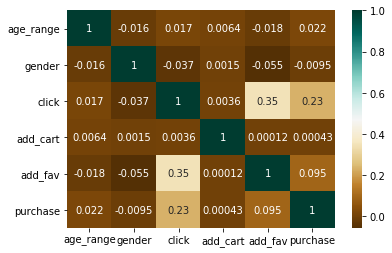

In [82]:
g = sns.heatmap(log_test[["age_range","gender",'click','add_cart','add_fav','purchase']][log_test.notnull()].corr(),cmap="BrBG",annot=True)

In [83]:
log_test['age_range'].median()

3.0

In [84]:
log_test[["age_range","gender"]].groupby('age_range').mean()

,gender
age_range,
1.0,0.153846
2.0,0.349903
3.0,0.278946
4.0,0.311435
5.0,0.287693
6.0,0.271378
7.0,0.306412
8.0,0.386530


In [85]:
log_test[["age_range","gender"]].groupby('age_range').mean().loc[2.0,'gender']

0.34990333256873218

In [86]:
log_test['gender'].value_counts()

0.0    176414
1.0     73756
Name: gender, dtype: int64

In [87]:
#so we can fill gender NaN with a binomial Dist. (1,pi(male))  pi(male)~=2/(2+5)  <=1086:2510
log_test.loc[log_test['gender'].isnull(),'gender']=np.random.binomial(1,0.3)

In [88]:
log_test['gender'].isnull().sum()

0

In [89]:
log_test.describe()

,user_id,age_range,gender,merchant_id,label,act_times,click,add_cart,purchase,add_fav
count,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000
mean,211889.321420,3.600320,0.282737,2540.292363,0.061151,10.798558,9.077044,0.000092,1.369518,0.386826
std,122399.488027,1.190957,0.450331,1451.207514,0.239607,19.805637,19.032752,0.016381,1.146741,1.426118
min,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,105488.000000,3.000000,0.000000,1340.000000,0.000000,3.000000,2.000000,0.000000,1.000000,0.000000
50%,211927.500000,3.000000,0.000000,2482.000000,0.000000,6.000000,4.000000,0.000000,1.000000,0.000000
75%,317670.500000,4.000000,1.000000,3898.000000,0.000000,12.000000,10.000000,0.000000,1.000000,0.000000
max,424170.000000,8.000000,1.000000,4993.000000,1.000000,3918.000000,3917.000000,7.000000,132.000000,107.000000


In [90]:
log_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 6 to 7030721
Data columns (total 11 columns):
user_id        260864 non-null int64
age_range      260864 non-null float64
gender         260864 non-null float64
merchant_id    260864 non-null int64
label          260864 non-null int64
item_list      260864 non-null object
act_times      260864 non-null int64
click          260864 non-null int64
add_cart       260864 non-null int64
purchase       260864 non-null int64
add_fav        260864 non-null int64
dtypes: float64(2), int64(8), object(1)
memory usage: 23.9+ MB


In [91]:
# Outlier detection 
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

Outliers_to_drop = detect_outliers(log_test,20,["click"])
Outliers_to_drop

[]

In [92]:
log_test.head()

,user_id,age_range,gender,merchant_id,label,item_list,act_times,click,add_cart,purchase,add_fav
6,34176,6.0,0.0,3906,0,"[757713, 757713, 757713, 718096, 757713, 61369...",39,36,0,1,2
30,34176,6.0,0.0,121,0,"[800752, 800752, 800752, 800752, 800752, 80075...",14,13,0,1,0
40,34176,6.0,0.0,4356,1,"[709909, 709909, 709909, 709909, 709909, 70990...",18,12,0,6,0
63,34176,6.0,0.0,2217,0,"[399879, 399879]",2,1,0,1,0
117,230784,3.0,0.0,4818,0,"[155695, 155695, 155695, 155695, 155695, 15569...",8,7,0,7,0


In [93]:
# dummy age_range
log_test = pd.get_dummies(log_test, columns=['age_range'])

In [94]:
log_test.head(2)

,user_id,gender,merchant_id,label,item_list,act_times,click,add_cart,purchase,add_fav,age_range_1.0,age_range_2.0,age_range_3.0,age_range_4.0,age_range_5.0,age_range_6.0,age_range_7.0,age_range_8.0
6,34176,0.0,3906,0,"[757713, 757713, 757713, 718096, 757713, 61369...",39,36,0,1,2,0,0,0,0,0,1,0,0
30,34176,0.0,121,0,"[800752, 800752, 800752, 800752, 800752, 80075...",14,13,0,1,0,0,0,0,0,0,1,0,0


In [109]:
train_df = log_test.filter(regex='label|age_.*|gender|click|add_.*|purchase')
train_df.head()

,gender,label,click,add_cart,purchase,add_fav,age_range_1.0,age_range_2.0,age_range_3.0,age_range_4.0,age_range_5.0,age_range_6.0,age_range_7.0,age_range_8.0
6,0.0,0,36,0,1,2,0,0,0,0,0,1,0,0
30,0.0,0,13,0,1,0,0,0,0,0,0,1,0,0
40,0.0,1,12,0,6,0,0,0,0,0,0,1,0,0
63,0.0,0,1,0,1,0,0,0,0,0,0,1,0,0
117,0.0,0,7,0,7,0,0,0,1,0,0,0,0,0


In [110]:
sex = train_df['gender']
train_df.drop('gender', axis=1, inplace=True)
train_df.insert(1,'gender',sex)
train_df.head()

,label,gender,click,add_cart,purchase,add_fav,age_range_1.0,age_range_2.0,age_range_3.0,age_range_4.0,age_range_5.0,age_range_6.0,age_range_7.0,age_range_8.0
6,0,0.0,36,0,1,2,0,0,0,0,0,1,0,0
30,0,0.0,13,0,1,0,0,0,0,0,0,1,0,0
40,1,0.0,12,0,6,0,0,0,0,0,0,1,0,0
63,0,0.0,1,0,1,0,0,0,0,0,0,1,0,0
117,0,0.0,7,0,7,0,0,0,1,0,0,0,0,0


In [111]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split



train_np = train_df#.as_matrix()

y_train = train_np.iloc[:, 0].values
X_train = train_np.iloc[:, 1:].values

kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
LogReg = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6, solver='sag')
scores = []
for k, (train, test) in enumerate(kfold):
    LogReg.fit(X_train[train], y_train[train])
    score = LogReg.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]), score))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold:  1, Class dist.: [220420  14356], Acc: 0.939
Fold:  2, Class dist.: [220420  14356], Acc: 0.939
Fold:  3, Class dist.: [220421  14357], Acc: 0.939
Fold:  4, Class dist.: [220421  14357], Acc: 0.939
Fold:  5, Class dist.: [220421  14357], Acc: 0.939
Fold:  6, Class dist.: [220421  14357], Acc: 0.939
Fold:  7, Class dist.: [220421  14357], Acc: 0.939
Fold:  8, Class dist.: [220421  14357], Acc: 0.939
Fold:  9, Class dist.: [220421  14357], Acc: 0.939
Fold: 10, Class dist.: [220421  14357], Acc: 0.939
CV accuracy: 0.939 +/- 0.000


In [112]:
train_np.iloc[:, 1:].shape

(260864, 13)

In [113]:
y_train = train_np.iloc[:, 0]
X_train = train_np.iloc[:, 1:]
kfold = StratifiedKFold(n_splits=10)
LogReg = linear_model.LogisticRegression()
logreg_param_grid = {'solver': ['newton-cg','sag','lbfgs'], 
                  'C': [1, 10, 50, 100]}

gsLogReg = GridSearchCV(LogReg,param_grid = logreg_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLogReg.fit(X_train,y_train)

LogReg_best = gsLogReg.best_estimator_

# Best score
gsLogReg.best_score_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: Convergen

/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.5min finished
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.93883786187438667

In [114]:
test = pd.read_csv("./data_format2/test_format2.csv")
test =  test.fillna(np.nan)
# Just ignore the former buyer(label=-1)
test = test[test.label != -1.0]

# Fill the log with '' in order to to string.split()
test['activity_log']=test['activity_log'].fillna('')


# 0 for unknow age describled in the official site
# 2 for unknow gender describled in the official site
# but we wanna see the mean and std, so change these values to NaN
# and then to insert with the vaule which we want.(i.e. mean, mode, etc.)
test.loc[test['age_range']==0,'age_range']=np.nan
test.loc[test['gender']==2,'gender']=np.nan

# item_id:category_id:brand_id:time_stamp:action_type
# act_type:{0, 1, 2, 3}, 
#      0 is for click, 
#      1 is for add-to-cart
#      2 is for purchase 
#      3 is for add-to-favourite
#log_test['log_list'] = log_test['activity_log'].apply(lambda x: [i.split(':') for i in x.split('#')])
test['item_list'] = test['activity_log'].apply(lambda x: [i.split(':')[0] for i in x.split('#')])
#log_test['cat_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[1] for i in x.split('#')])
#log_test['brand_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[2] for i in x.split('#')])
#log_test['time_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[3] for i in x.split('#')])
#log_test['act_list'] = log_test['activity_log'].apply(lambda x: [i.split(':')[4] for i in x.split('#')])
test['act_times'] = test['item_list'].apply(len)
test['click'] = test['activity_log'].apply(lambda x: [i.split(':').count('0') for i in x.split('#')].count(1))
test['add_cart'] = test['activity_log'].apply(lambda x: [i.split(':').count('1') for i in x.split('#')].count(1))
test['purchase'] = test['activity_log'].apply(lambda x: [i.split(':').count('2') for i in x.split('#')].count(1))
test['add_fav'] = test['activity_log'].apply(lambda x: [i.split(':').count('3') for i in x.split('#')].count(1))
test.drop(['activity_log'],axis=1,inplace=True)

test.loc[test['age_range'].isnull(),'age_range'] = np.random.binomial(1,0.5)+3
test.loc[test['gender'].isnull(),'gender']=np.random.binomial(1,0.3)

test = pd.get_dummies(test, columns=['age_range'])

test_df = test.filter(regex='label|age_.*|gender.*|click|add_.*|purchase')

sex = test_df['gender']
test_df.drop('gender', axis=1, inplace=True)
test_df.insert(1,'gender',sex)

test_df.head()

,label,gender,click,add_cart,purchase,add_fav,age_range_1.0,age_range_2.0,age_range_3.0,age_range_4.0,age_range_5.0,age_range_6.0,age_range_7.0,age_range_8.0
12,NaN,0.0,1,0,1,0,0,0,0,1,0,0,0,0
53,NaN,0.0,5,0,5,0,0,1,0,0,0,0,0,0
65,NaN,0.0,5,0,1,0,0,0,0,0,0,1,0,0
67,NaN,0.0,10,0,1,0,0,0,0,0,0,1,0,0
134,NaN,1.0,47,0,1,2,0,1,0,0,0,0,0,0


In [115]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261477 entries, 12 to 7027926
Data columns (total 14 columns):
label            0 non-null float64
gender           261477 non-null float64
click            261477 non-null int64
add_cart         261477 non-null int64
purchase         261477 non-null int64
add_fav          261477 non-null int64
age_range_1.0    261477 non-null uint8
age_range_2.0    261477 non-null uint8
age_range_3.0    261477 non-null uint8
age_range_4.0    261477 non-null uint8
age_range_5.0    261477 non-null uint8
age_range_6.0    261477 non-null uint8
age_range_7.0    261477 non-null uint8
age_range_8.0    261477 non-null uint8
dtypes: float64(2), int64(4), uint8(8)
memory usage: 16.0 MB


In [116]:
test_df.isnull().sum()

label            261477
gender                0
click                 0
add_cart              0
purchase              0
add_fav               0
age_range_1.0         0
age_range_2.0         0
age_range_3.0         0
age_range_4.0         0
age_range_5.0         0
age_range_6.0         0
age_range_7.0         0
age_range_8.0         0
dtype: int64

In [119]:
y_pred = LogReg_best.predict(test_df.iloc[:,1:])

np.unique(y_pred)

array([0])

In [118]:
len(y_pred)

261477

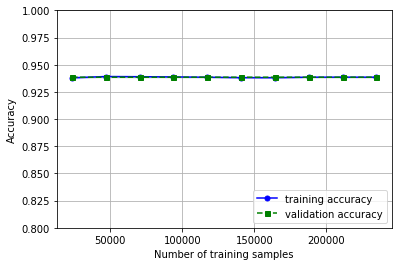

In [120]:
from sklearn.model_selection import learning_curve

y_train = train_np.iloc[:, 0]
X_train = train_np.iloc[:, 1:]

LogReg2 = LogisticRegression(penalty='l2',random_state=1)
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=LogReg2,X=X_train,y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='training accuracy')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [121]:
#
# RF
#

from sklearn.ensemble import RandomForestClassifier

y = train_np.iloc[:, 0]
X = train_np.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, criterion='gini')

rfc.fit(X_train,y_train)


print(accuracy_score(y_test, rfc.predict(X_test)))

y_pred = rfc.predict(test_df.iloc[:,1:])

y_pred.sum()

0.935866459122


1367

In [124]:
result = pd.DataFrame({'user_id':test['user_id'].as_matrix(), 
                       'merchant_id':test['merchant_id'].as_matrix(), 
                       'label':y_pred.astype(np.int32)},
                     columns=['user_id','merchant_id','label'])
result.head()

,user_id,merchant_id,label
0,163968,4605,0
1,360576,1581,0
2,98688,1964,0
3,98688,3645,0
4,295296,3361,1


In [125]:
result.to_csv("./RF_a_s_action.csv", index=False)
#
# End of RF
#

/root/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/root/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/root/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/root/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/root/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/root/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/root/anaconda3/

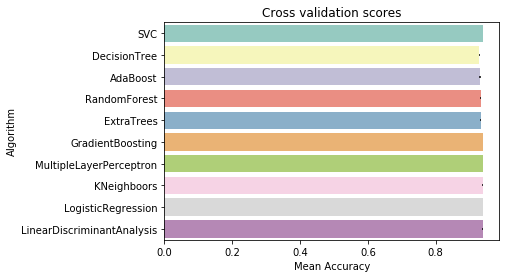

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)